# **Atakeen sailkapena konputagailuen arteko komunikazioetan grafo egiturak erabiliz, train-erako hainbat grafo erabilita**

Beharko ditugun liburutegiak:

In [3]:
from google.colab import drive
import numpy as np
import pandas as pd
from sklearn import metrics, linear_model
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
import math
import random
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import MessagePassing
import tensorflow as tf
import os
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"
from scipy.linalg import fractional_matrix_power
import csv

Instalatu beharrekoak:

In [ ]:
!pip install torch_geometric
!pip install pandas
!pip install numpy
!pip install scipy==1.8.0
!pip install networkx

## **Datuak kargatzen**

In [13]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **CSV-ak irakurri eta bakar batean elkartu**

BETH datu-multzoa CSV desberdinetan banatuta dago. Beraz, taula hauek batean batu behar dira.

In [14]:
path = '/content/drive/MyDrive/GrAL/DATUAK/ELKARTZEKO'
files = [os.path.join(path, file) for file in os.listdir(path)]
taula = pd.concat(map(pd.read_csv, files), ignore_index=True)
originala = pd.concat(map(pd.read_csv, files), ignore_index=True)

##**CSV-a moldatu**

Bi taula desberdin erabiliko dira, taula originala, aldaketarik gabekoa, eta moldatutako taula, honek datuak aurreprozesatuta gordeko ditu.

In [15]:
taula = taula[["processId", "parentProcessId", "userId", "eventId", "argsNum", "returnValue", "evil"]]
originala = originala[["processId", "parentProcessId", "userId", "eventId", "argsNum", "returnValue", "evil"]]


# Preprocessing
taula["processId"] = taula["processId"].map(lambda x: 1 if x in [0, 1, 2] else 0)
taula["parentProcessId"] = taula["parentProcessId"].map(lambda x: 1 if x in [0, 1, 2] else 0)
taula["userId"] = taula["userId"].map(lambda x: 1 if x < 1000 else 0)
taula["eventId"] = taula["eventId"]
taula["argsNum"] = taula["argsNum"]
taula["returnValue"] = taula["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))


# CSV berriak sortu
taula.to_csv('dataset.csv')
originala.to_csv('orig_dataset.csv')

## **Sailkapenak egiteko erabiliko diren ezaugarrien zerrenda prestatzeko**

Lehendabizi, aurretik prestatutako taula berriak irakurriko dira.

In [16]:
# Aurre-prozesatua
with open('/content/dataset.csv',newline='') as f:
    r = csv.reader(f)
    data = [line for line in r]

# Originala
with open('/content/orig_dataset.csv',newline='') as f:
    r2 = csv.reader(f)
    data_orig = [line for line in r2]

Ondoren, entrenamendurako erabiliko diren ezaugarrien zerrendak prestatuko dira.

In [8]:
#################### TRAIN ####################
# EZAUGARRIEN ZERRENDA
max = 9000
kop = 0
nodoak = []
ezaugarriak = []
ertzak = []
unekoGur = ""
unekoUm = ""
ertzaGehitu = True
hasiera = 0
ezaugarri_zerrenda = []
ertz_zerrenda = []

# Entrenamendurako 852 grafo, eta grafo bakoitzak 20 nodo izanda. Guztira 17040 nodo inguru, eta hauetatik 4174 erasotzaileak.
for i in range(1, len(data_orig)-2000000):

  if len(ezaugarriak) < 20:

    ertzaGehitu = True

    # PROZESU GURASOA
    # Ez bada prozesu gurasoaren identifikatzailea nodoak zerrendan txertatu
    if not int(data_orig[i][2]) in nodoak:
      nodoak.append(int(data_orig[i][2]))
      ezaugarriak.append([-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, 0.0, kop])   # "-inf"-ekin erabili ostian, erroreak NaN delako infinito, visualize egitean erroreak.
      unekoGur = kop
      kop = kop+1
    else:     # Prozesu gurasoaren identifikatzailea nodoak zerrendan badago
      ind = nodoak.index(int(data_orig[i][2]))
      unekoGur = ezaugarriak[ind][7]

    # PROZESU UMEA
    # Dagoeneko existitzen bada prozesu umea nodoak zerrendan
    if int(data_orig[i][1]) in nodoak:
      ind = nodoak.index(int(data_orig[i][1]))

      if (ezaugarriak[ind][1]==-1000.0):      # Nodoak ez du ezaugarririk prozesu gurasoa izan delako. Ezaugarriak eguneratu beharko dira.
        unekoUm = ezaugarriak[ind][7]
        ezaugarriak[ind][0] = float(data[i][1])
        ezaugarriak[ind][1] = float(data[i][2])
        ezaugarriak[ind][2] = float(data[i][3])
        ezaugarriak[ind][3] = float(data[i][4])
        ezaugarriak[ind][4] = float(data[i][5])
        ezaugarriak[ind][5] = float(data[i][6])
        ezaugarriak[ind][6] = float(data[i][7])
      else:
        if (float(data[i][7]) == 1):          # Prozesua erasotzailea da
          nodoak.append(kop)
          ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
          unekoUm = kop
          # Ausazko ertzak sortzeko
          zenbat = random.randint(0, 10)
          for i in range(0, zenbat):
            zein = random.randint(0, 19)
            if (random.randint(0,1) == 0):
              if (unekoUm<20 and zein<20):
                ertzak.append([unekoUm, zein])
            else:
              if (unekoUm<20 and zein<20):
                ertzak.append([zein, unekoUm])
          kop = kop+1

        else:           # Prozesua ez da erasotzailea
          if max>0:
            nodoak.append(kop)
            ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
            unekoUm = kop
            max = max-1
            # Ausazko ertzak sortzeko
            zenbat = random.randint(0, 10)
            for i in range(0, zenbat):
              zein = random.randint(0, 19)
              if (random.randint(0,1) == 0):
                if (unekoUm<20 and zein<20):
                  ertzak.append([unekoUm, zein])
              else:
                if (unekoUm<20 and zein<20):
                  ertzak.append([zein, unekoUm])
            kop = kop+1
          else:
            ertzaGehitu = False

    else:
      nodoak.append(int(data_orig[i][1]))
      ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
      unekoUm = kop
      kop = kop+1

    if ertzaGehitu and unekoGur<20 and unekoUm<20:
      ertzak.append([unekoGur, unekoUm])


  else:
    ezaugarri_zerrenda.append(ezaugarriak)
    ertz_zerrenda.append(ertzak)
    nodoak = []
    ezaugarriak = []
    ertzak = []
    kop = 0



Ezaugarrien balioen arteko desberdintasuna hain handia izanik, balio hauek estandarizatu behar dira. Kasu honetan, Scikit-learn liburutegiak eskaintzen duen MinMaxScaler funtzioa erabili da.

Jarraian, `Data` objektuak sortzen dira eta zerrenda batean gehitzen dira.

In [9]:
scaler = MinMaxScaler()

In [10]:
data_zerrenda = []

for i in range(0, len(ezaugarri_zerrenda)):
  x = []
  y = []
  edge_index = []

  for j in range(0, len(ezaugarri_zerrenda[0])):
    x.append([ezaugarri_zerrenda[i][j][0], ezaugarri_zerrenda[i][j][1], ezaugarri_zerrenda[i][j][2], ezaugarri_zerrenda[i][j][3], ezaugarri_zerrenda[i][j][4], ezaugarri_zerrenda[i][j][5]])
    y.append(int(ezaugarri_zerrenda[i][j][6]))


  new_x = scaler.fit_transform(x)
  x = torch.tensor(new_x, dtype=torch.float)
  y = torch.tensor(y)
  matrix = np.transpose(ertz_zerrenda[i])
  matrix = np.vstack(matrix).astype(np.intc)
  edge_index = torch.tensor(matrix)
  data = Data(x=x, edge_index=edge_index, y=y)
  data_zerrenda.append(data)


Azkenik, probarako erabiliko den ezaugarrien zerrenda prestatuko da.

In [17]:
#################### TEST ####################
# EZAUGARRIEN ZERRENDA
max = 500
kop = 0
nodoak = []
ezaugarriak = []
ertzak = []
unekoGur = ""
unekoUm = ""
ertzaGehitu = True
hasiera = 0
ezaugarri_zerrenda = []
ertz_zerrenda = []

# 824 nodoko grafoa erabiliz, eta nodo hauetatik 106 erasotzaileak izanik.
for i in range(len(data_orig)-1550000, len(data_orig)-1399000):

  ertzaGehitu = True

  # PROZESU GURASOA
  # Ez bada prozesu gurasoaren identifikatzailea nodoak zerrendan txertatu
  if not int(data_orig[i][2]) in nodoak:
    nodoak.append(int(data_orig[i][2]))
    ezaugarriak.append([-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, -1000.0, 0.0, kop])   # "-inf"-ekin erabili ostian, erroreak NaN delako infinito, visualize egitean erroreak.
    unekoGur = kop
    kop = kop+1
  else:     # Prozesu gurasoaren identifikatzailea nodoak zerrendan badago
    ind = nodoak.index(int(data_orig[i][2]))
    unekoGur = ezaugarriak[ind][7]

  # PROZESU UMEA
  # Dagoeneko existitzen bada prozesu umea nodoak zerrendan
  if int(data_orig[i][1]) in nodoak:
    ind = nodoak.index(int(data_orig[i][1]))

    if (ezaugarriak[ind][1]==-1000.0):      # Nodoak ez du ezaugarririk prozesu gurasoa izan delako. Ezaugarriak eguneratu beharko dira.
      unekoUm = ezaugarriak[ind][7]
      ezaugarriak[ind][0] = float(data[i][1])
      ezaugarriak[ind][1] = float(data[i][2])
      ezaugarriak[ind][2] = float(data[i][3])
      ezaugarriak[ind][3] = float(data[i][4])
      ezaugarriak[ind][4] = float(data[i][5])
      ezaugarriak[ind][5] = float(data[i][6])
      ezaugarriak[ind][6] = float(data[i][7])
    else:
      if (float(data[i][7]) == 1):          # Prozesua erasotzailea da
        nodoak.append(kop)
        ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
        unekoUm = kop
        # Ausazko ertzak sortzeko
        zenbat = random.randint(0, 10)
        for i in range(0, zenbat):
          zein = random.randint(0, 19)
          if (random.randint(0,1) == 0):
              ertzak.append([unekoUm, zein])
          else:
              ertzak.append([zein, unekoUm])
        kop = kop+1

      else:           # Prozesua ez da erasotzailea
        if max>0:
          nodoak.append(kop)
          ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
          unekoUm = kop
          max = max-1
          # Ausazko ertzak sortzeko
          zenbat = random.randint(0, 10)
          for i in range(0, zenbat):
            zein = random.randint(0, 19)
            if (random.randint(0,1) == 0):
                ertzak.append([unekoUm, zein])
            else:
                ertzak.append([zein, unekoUm])
          kop = kop+1
        else:
          ertzaGehitu = False

  else:
    nodoak.append(int(data_orig[i][1]))
    ezaugarriak.append([float(data[i][1]), float(data[i][2]), float(data[i][3]), float(data[i][4]), float(data[i][5]), float(data[i][6]), float(data[i][7]), kop])
    unekoUm = kop
    kop = kop+1

  if ertzaGehitu:
    ertzak.append([unekoGur, unekoUm])


**x lortzeko:**

Grafoaren ezaugarri-matrizea da (hau da, grafoaren nodo bakoitzeko ezaugarriez osatutako zutabeak dituen matrizea).

**shape** `[num_nodes, num_node_features]`

In [18]:
x = []
for i in range(0,len(ezaugarriak)):
  x.append([ezaugarriak[i][0], ezaugarriak[i][1], ezaugarriak[i][2], ezaugarriak[i][3], ezaugarriak[i][4], ezaugarriak[i][5]])


new_x = scaler.fit_transform(x)
x = torch.tensor(new_x, dtype=torch.float)

**edge_index lortzeko:**

Grafoaren konektibitate-matrizea da, COO formatuan. Konektatuta dauden nodoen zerrenda bakarrik gordetzen da, grafoaren auzokide matrize osoa gorde beharrean.

**shape** `[2, num_edges]`

In [19]:
matrix = np.transpose(ertzak)
matrix = np.vstack(matrix).astype(np.intc)
edge_index = torch.tensor(matrix)

**y lortzen:**

Nodo bakoitzaren etiketa-matrizea da (bi klasetatik nodo bakoitza zeini dagokion adieraziko du).

In [20]:
y = []
for i in range(0,len(ezaugarriak)):
  y.append(int(ezaugarriak[i][6]))

y = torch.tensor(y)

In [21]:
# Zenbat nodo erasotzaile dauden guztira eta indizeak
kont = 0
indizeak = []
for k in range(0, len(y)):
  if (y[k]==1):
    indizeak.append(k)
    kont = kont+1

print("Kopurua: ", kont)
print("Indizeak: ", indizeak)

Kopurua:  106
Indizeak:  [715, 719, 720, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737, 738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750, 751, 752, 753, 754, 755, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 797, 798, 799, 800, 801, 802, 803, 804, 805, 806, 807, 808, 809, 810, 811, 812, 813, 814, 815, 816, 817, 818, 819, 820, 821, 822, 823]


#### **Data objektua sortzeko**

In [22]:
# Data objektua sortzeko
from torch_geometric.data import Data

data = Data(x=x, edge_index=edge_index, y=y)

_________________________________________________________________________________________________________

## **GCN EREDUA**

GCN eredua sortzen da, lau GCNConv geruzarekin.

In [23]:
class GCN(MessagePassing):

    def __init__(self, hidden_channels, num_features, num_classes):
        # __init__()-en, klase nagusira deitu behar da bigarren klaseari esleipenak egin aurretik.
        super().__init__()

        # Ausazko zenbakiak sortzeko hazia ezartzen du. torch.Generator motako objektua itzultzen du.
        # PyTorchen ausazkotasuna kontrolatzen laguntzen duen funtzioa da.
        torch.manual_seed(42)

        # INITIALIZING THE LAYERS
        # Lehenengo, GCN geruza kopurua definitzen da.
        # Kasu honetan, Message Passing-a burutzeko lau geruza ditu.
        # GCN layers (message passing layers)
        self.conv1 = GCNConv(num_features, hidden_channels)     # Lehenengo geruza
        self.conv2 = GCNConv(hidden_channels, hidden_channels)      # Bigarren geruza
        self.conv3 = GCNConv(hidden_channels, hidden_channels)      # Hirugarren geruza
        self.conv4 = GCNConv(hidden_channels, hidden_channels)      # Laugarren geruza

        # Transformazio lineal bakarra aplikatzen da (torch.nn.Linear), eta honek, sailkatzaile gisa jarduten du (nodoak 0 edo 1 klasean sailkatzeko).
        # Output layer, sailkatzailea
        self.out = Linear(hidden_channels, num_classes)


    # Sarearen konputazio-fluxua definitzeko (forward)
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()      # Lehenengo Message Passing Layer
        h = self.conv2(h, edge_index).relu()      # Bigarren Message Passing Layer
        h = self.conv3(h, edge_index).relu()      # Hirugarren Message Passing Layer
        h = self.conv4(h, edge_index).relu()      # Laugarren Message Passing Layer
        out = self.out(h)
        return out, h


In [24]:
# num_features --> Nodoen ezaugarriak (data.num_features)
# num_classes = 2 (Erasoa edo ez, hau da, nodo bat erasotzailea den edo ez)
# Ereduak 16 kanal ezkutu izango ditu.
model = GCN(hidden_channels=16, num_features=6, num_classes=2)

# Sare-arkitektura definitzeaz gain, CrossEntropyLoss funtzioa definitzen da, eta Adam optimizatzailea hasieratzen da.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, weight_decay=5e-4
criterion = torch.nn.CrossEntropyLoss()

def train():

      # model.train() funtzioak, eredua entrenatzen ari dela adierazten du, hau da, ez du eredua entrenatzen, baizik eta modua ezartzen du. Honek, Dropout
      # eta BatchNorm bezalako geruzak informatzen laguntzen du, entrenamenduan eta ebaluazioan desberdin jokatzeko diseinatuta baitaude.
      # Adibidez, entrenamendu-moduan, BatchNorm-ek batezbesteko mugikor bat eguneratzen du lote berri bakoitzean; ebaluaziorako, berriz, eguneratze horiek
      # izoztuta daude.
      model.train()

      for epoch in range(10):
          for i in range(0, len(data_zerrenda)):
            optimizer.zero_grad()  # Clear gradients.
            out, h = model(data_zerrenda[i].x, data_zerrenda[i].edge_index)  # Perform a single forward pass.
            loss = criterion(out, data_zerrenda[i].y)  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            optimizer.step()  # Update parameters based on gradients.


def test():
      model.eval()      # model.eval() erabiltzean ereduari adierazten zaio ez dela ezer berririk ikasi behar, eta eredua probatzeko erabiltzen da.
      out, h = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred == data.y  # Check against ground-truth labels.
      return pred, data.y, test_correct.sum()

#### **TRAIN**

In [25]:
# Eredua entrenatzen da
train()

#### **TEST**

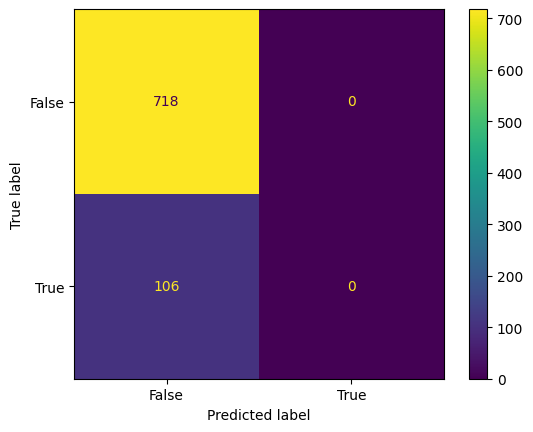

In [26]:
# Eredua probatzen da
pred, actual, test_correct = test()

# Test-aren konfusio-matrizea
confusion_matrix = metrics.confusion_matrix(actual, pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [ ]:
# Precision balioek adierazten dute negatibotzat, edo 0 klasean, sailkatu diren datuen artetik zenbat sailkatu direla ondo, eta positibotzat, edo 1 klasean,
# sailkatu diren datuen artetik zenbat sailkatu direla ondo.
metrics.precision_score(actual, pred, average=None)

array([0.87135922, 0.        ])

In [ ]:
# Recall balioek adierazten dute ereduak egiazko negatiboak eta egiazko positiboak identifikatzeko gaitasuna.
metrics.recall_score(actual, pred, average=None)

array([1., 0.])

In [ ]:
# F1 balioak
metrics.f1_score(actual, pred, average=None)

array([0.93125811, 0.        ])